# PDEs & UFL 2:

## Linear Elasticity
We will borrow a lot from the tutorial:

https://jsdokken.com/dolfinx-tutorial/chapter2/linearelasticity_code.html

$$
\nabla \cdot \sigma(u)= f   
$$

$$
\sigma(u)=\lambda \text{Tr}(\epsilon)I+2\mu \epsilon
$$

$$
\epsilon = \frac{1}{2}(\nabla u+\nabla u^T)
$$


We can substitute everything in terms of u and get something like navier stokes but for elasticity this is more convenient.

Note:

$\sigma, \epsilon$ are tensors


The weak form is:

$$
\int_{\Omega}\sigma(\vec{u}) : \nabla \vec{v} dx =\int_{\Omega}\vec{f}\cdot \vec{v} dx+\int_{\partial \Omega}\vec{T}\cdot \vec{v}ds  
$$

Solve for u

we will simulate the problem of beam bending through its own weight

In [1]:
#please run twice
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9b21f39/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [2]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

import pyvista
pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True

In [3]:
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from dolfinx import mesh, fem, plot, io

In [4]:
L=1
W=0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma


domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0,0,0]), np.array([L, W, W])],[20,6,6], cell_type=mesh.CellType.hexahedron)
# the mesh
V = fem.VectorFunctionSpace(domain, ("CG", 1))
# the vector function Approximation Space

Clamped boundary at x=0



In [5]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)

fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

dofs=fem.locate_dofs_topological(V, fdim, boundary_facets)

u_D = np.array([0,0,0], dtype=ScalarType)
bc = fem.dirichletbc(u_D, dofs, V)

$$ \sigma .\hat{n}=\vec{T}=\mathbf{0}
$$
on other boundaries

In [6]:
T = fem.Constant(domain, ScalarType((0, 0, 0)))

In [7]:
from ufl import ds,dx

In [8]:
mu=1.5
lambda_=1


def strain(u):
  return 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)



def stress(u):
  return 2*mu*strain(u)+lambda_*ufl.tr(strain(u))*ufl.Identity(3)



#let's make the material very heavy

f_z=5

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, ScalarType((0, 0, -1*rho*g)))
a = ufl.inner(stress(u), ufl.grad(v)) * dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

In [9]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

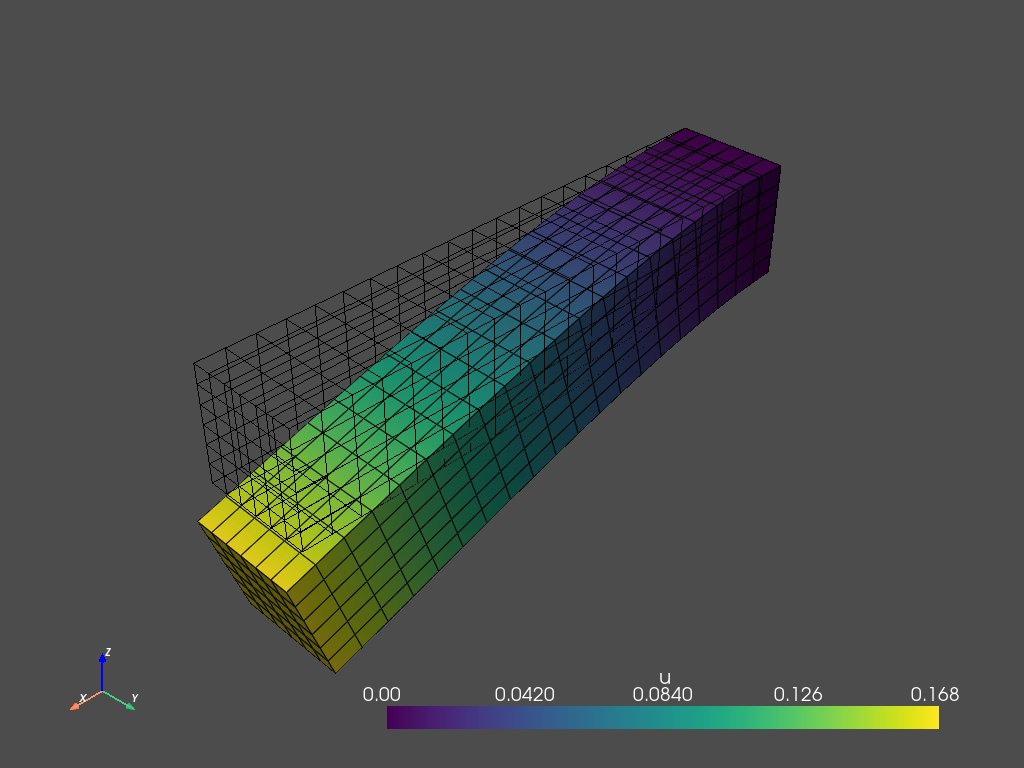

In [10]:
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   figure_as_array = p.screenshot("deflection.png")